In [19]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import norm
import seaborn as sns
import math
from scipy.optimize import curve_fit

In [2]:
g = nx.DiGraph()

In [3]:
nodes = pd.read_csv("../data/nodes.csv")
nodes.drop(nodes.columns[[0, 5]], axis=1, inplace=True)
nodes.columns = nodes.columns.str.lstrip()
rows_as_dicts = nodes.to_dict('index')
nodes


,name,code,region,sub_region
0,Afghanistan,4,Asia,Southern Asia
1,Albania,8,Europe,Southern Europe
2,Algeria,12,Africa,Northern Africa
3,American Samoa,16,Oceania,Polynesia
4,Andorra,20,Europe,Southern Europe
...,...,...,...,...
227,Wallis and Futuna Islands,876,Oceania,Polynesia
228,Western Sahara,732,Africa,Northern Africa
229,Yemen,887,Asia,Western Asia
230,Zambia,894,Africa,Eastern Africa


In [4]:
for i, attrs in rows_as_dicts.items():
    g.add_node(i, **attrs)

In [5]:
edges = pd.read_csv("../data/edges.csv")
edges.rename(columns={edges.columns[0]: 'source'}, inplace=True)
edges.columns = edges.columns.str.lstrip()
edges["migration_total"] = edges.filter(like = "total").sum(axis = 1)
edges["female_total"] = edges.filter(like = "female").sum(axis = 1)
edges["male_total"] = edges["migration_total"] - edges["female_total"]
edges = edges.set_index(['source', 'target'])
edges

migration_1990_total  migration_1990_male  \
source target                                              
0      64                       237                  194   
       118                      677                  556   
       142                       64                   26   
       191                       59                   37   
       202                     8485                 3726   
...                             ...                  ...   
231    220                     4767                 2148   
       11                      8265                 4184   
       147                      676                  323   
       68                         0                    0   
       28                         0                    0   

               migration_1990_female  migration_1995_total  \
source target                                                
0      64                         43                   188   
       118                       121                   452   
       142                        38                    61   
       191                        22                    36   
       202                      4759                 12248   
...                              ...                   ...   
231    220                      2619                  7571   
       11                       4081                 10498   
       147                       353                   822   
       68                          0                     0   
       28                          0                     0   

               migration_1995_male  migration_1995_female  \
source target                                               
0      64                      150                     38   
       118                     351                    101   
       142                      25                     36   
       191                      24                     12   
       202                    5518                   6730   
...                            ...                    ...   
231    220                    3451                   4120   
       11                     5291                   5207   
       147                     398                    424   
       68                        0                      0   
       28                        0                      0   

               migration_2000_total  migration_2000_male  \
source target                                              
0      64                       154                  117   
       118                      236                  155   
       142                       58                   23   
       191                       30                   20   
       202                    17118                 7874   
...                             ...                  ...   
231    220                    10686                 4909   
       11                     12110                 6110   
       147                     2807                 1365   
       68                         0                    0   
       28                         0                    0   

               migration_2000_female  migration_2005_total  ...  \
source target                                               ...   
0      64                         37                   183  ...   
       118                        81                   259  ...   
       142                        35                    45  ...   
       191                        10                    47  ...   
       202                      9244                 12636  ...   
...                              ...                   ...  ...   
231    220                      5777                 26585  ...   
       11                       6000                 21690  ...   
       147                      1442                  7794  ...   
       68                          0                     0  ...   
       28                          0            

In [6]:
for i, attrs in edges.to_dict('index').items():
    g.add_edge(*i, **attrs)

In [7]:
unique_regions = set(nx.get_node_attributes(g, 'region').values())
color_map = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}
node_colors = [color_map[g.nodes[node]['region']] for node in g.nodes()]

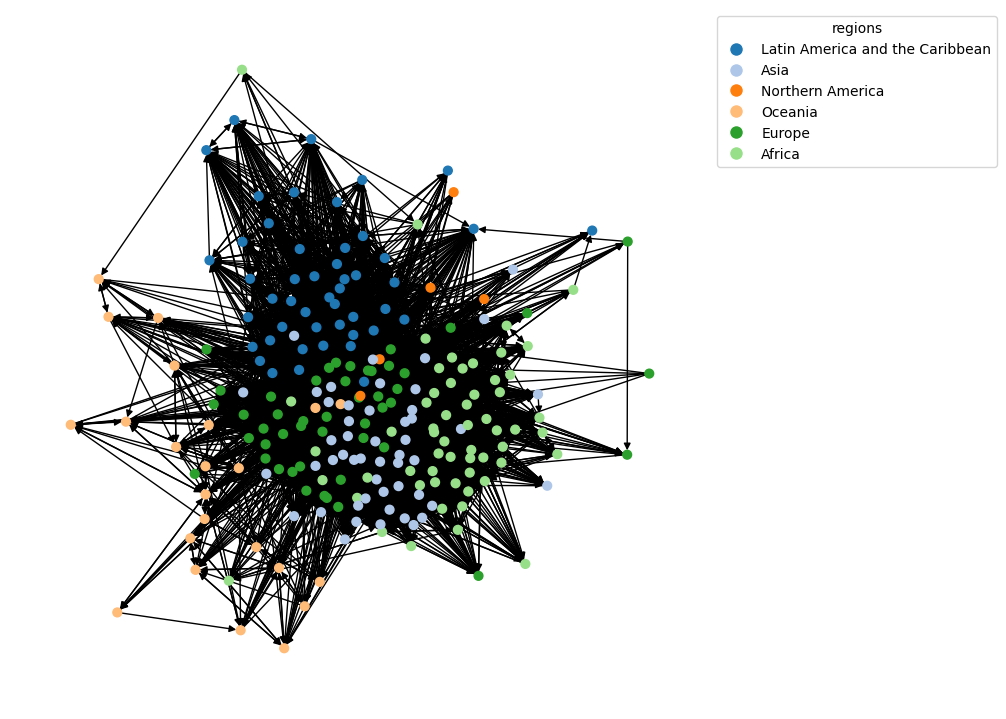

In [8]:
plt.figure(figsize=(7, 7))
nx.draw(g, node_color=node_colors, with_labels=False, node_size = 40, pos=nx.spring_layout(g, seed = 8))
region_patches = [plt.Line2D([0], [0], marker='o', color='w', label=region,
                          markerfacecolor=color, markersize=10)
                     for region, color in color_map.items()]
plt.legend(handles=region_patches, title="regions", loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [9]:
nn = nx.number_of_nodes(g)
ne = nx.number_of_edges(g)
print("Number of nodes: ", nn)
print("Number of edges: ",  ne)

Number of nodes:  232
Number of edges:  11228


In [10]:
density = nx.density(g)
weakly_connected = nx.is_weakly_connected(g)
strongly_connected = nx.is_strongly_connected(g)

print("Density:", density)
print("The graph", "is" if weakly_connected else "isn't" , "weakly connected")
print("The graph", "is" if strongly_connected else "isn't" , "strongly connected")

Density: 0.20950888192267503
The graph is weakly connected
The graph isn't strongly connected


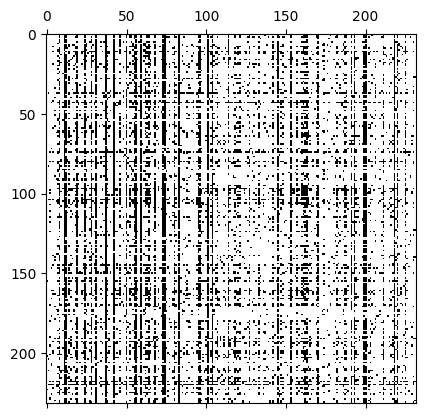

In [53]:
adj_matrix = nx.adjacency_matrix(g)
plt.spy(adj_matrix.todense())
plt.show()

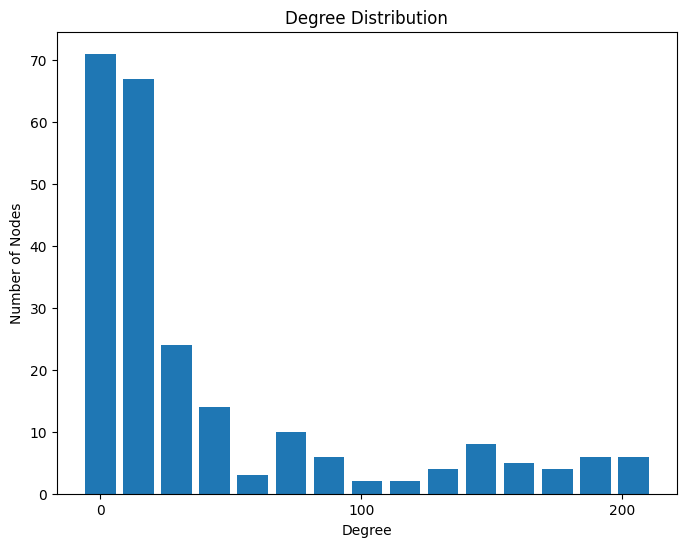

In [11]:
out_degrees = [degree for node, degree in g.out_degree]
in_degrees = [degree for node, degree in g.in_degree]
degrees = [degree for _, degree in g.degree]

plt.figure(figsize=(8, 6))
plt.hist(in_degrees, align='left', rwidth=0.8, bins = "auto")
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.xticks(range(0, max(in_degrees) + 1, 100))
plt.show()

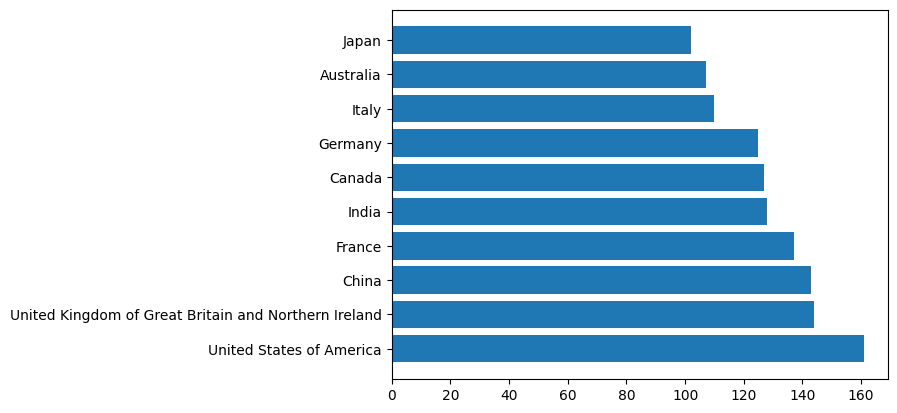

In [24]:
sorted_outd = sorted(g.out_degree(), key=lambda x:x[1], reverse = True)
plt.barh([g.nodes[id].get("name") for id, _ in sorted_outd[:10]], [value for _, value in sorted_outd[:10]])
plt.show()

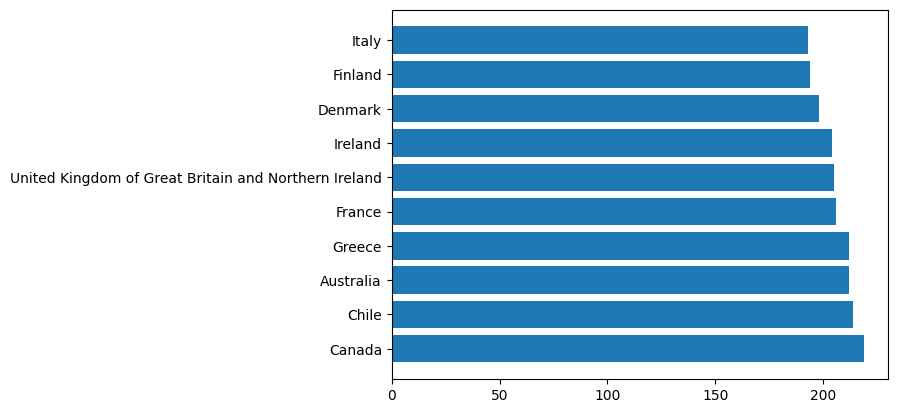

In [25]:
sorted_ind = sorted(g.in_degree(), key=lambda x:x[1], reverse = True)
plt.barh([g.nodes[id].get("name") for id, _ in sorted_ind[:10]], [value for _, value in sorted_ind[:10]])
plt.show()

## Centralities

In [11]:
spectral_radius = 1/max(nx.adjacency_spectrum(g, weight = 'migration_total')).real


In [12]:
centralities = {}
centralities["In_degree"] = dict(g.in_degree())
centralities["Out_degree"] = dict(g.out_degree())
centralities["In_strength"] = dict(g.in_degree(weight = 'migration_total'))
centralities["Out_strength"] = dict(g.out_degree(weight = 'migration_total'))
centralities["Betweenness"] = nx.betweenness_centrality(g)
centralities["Closeness"] = nx.closeness_centrality(g)
centralities["Katz"] = nx.katz_centrality(g, alpha=0.95*spectral_radius, weight = 'migration_total')
centralities["Left_Eigenvector"] = nx.eigenvector_centrality(g.reverse(), weight = 'migration_total')
centralities["Right_Eigenvector"] = nx.eigenvector_centrality(g, weight = 'migration_total')

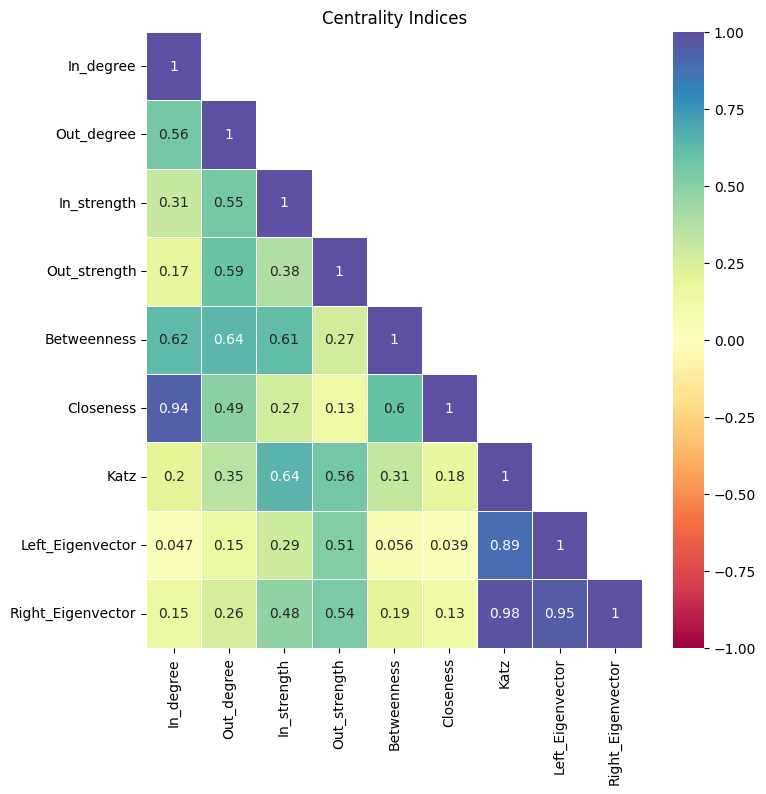

In [13]:
centralities_df = pd.DataFrame(centralities)
corr_matrix = centralities_df.corr(method="pearson")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
np.fill_diagonal(mask, False)
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap=sns.color_palette("Spectral", as_cmap=True), vmin=-1, vmax=1, linewidths=0.5, mask=mask)
plt.title('Centrality Indices')
plt.show()

In [37]:
def get_top(centrality, n = 10):
    sorted_centrality = list((({k: v for k, v in sorted(centrality.items(), key = lambda item: item[1], reverse = True)}).items()))
    return sorted_centrality[:n]
    

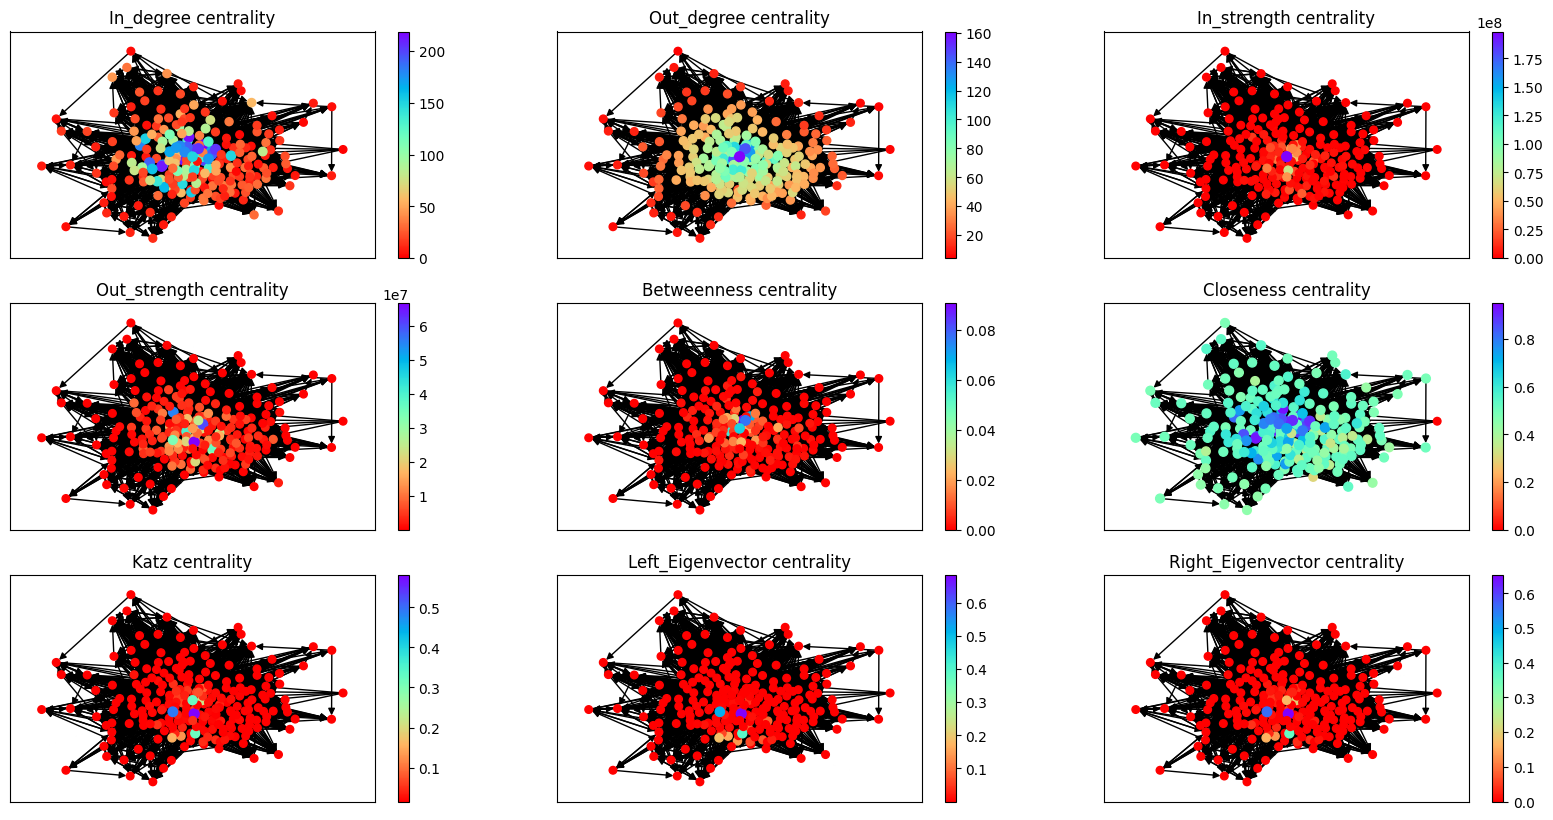

In [14]:
_, subp = plt.subplots(math.ceil(len(centralities)/3), 3, figsize=(20, 10))
for idx, (k, v) in enumerate(centralities.items()):
    i = idx % 3
    j = math.floor(idx / 3)
    vmin = min(v.values())
    vmax = max(v.values())
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colors = [plt.cm.rainbow_r(norm(v[x])) for x in g.nodes]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow_r, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, orientation='vertical', ax = subp[j][i])
    nx.draw_networkx(g, pos=nx.spring_layout(g, seed = 8),  
                     ax = subp[j][i], node_size = np.interp(list(v.values()), (vmin, vmax), [30,50]),
                     with_labels=False, node_color = colors)
    subp[j][i].set(title = f"{k} centrality")
plt.show()

In [16]:
def closest_power_of_10(num):
    log_val = math.log10(num)
    rounded_log = round(log_val)
    closest_power = 10 ** rounded_log
    return closest_power

/tmp/ipykernel_2680/1741630943.py:11: RuntimeWarning: divide by zero encountered in log
  popt, _ = curve_fit(fitf, np.log(bins[1:]), np.log(ccdf))


ValueError: array must not contain infs or NaNs

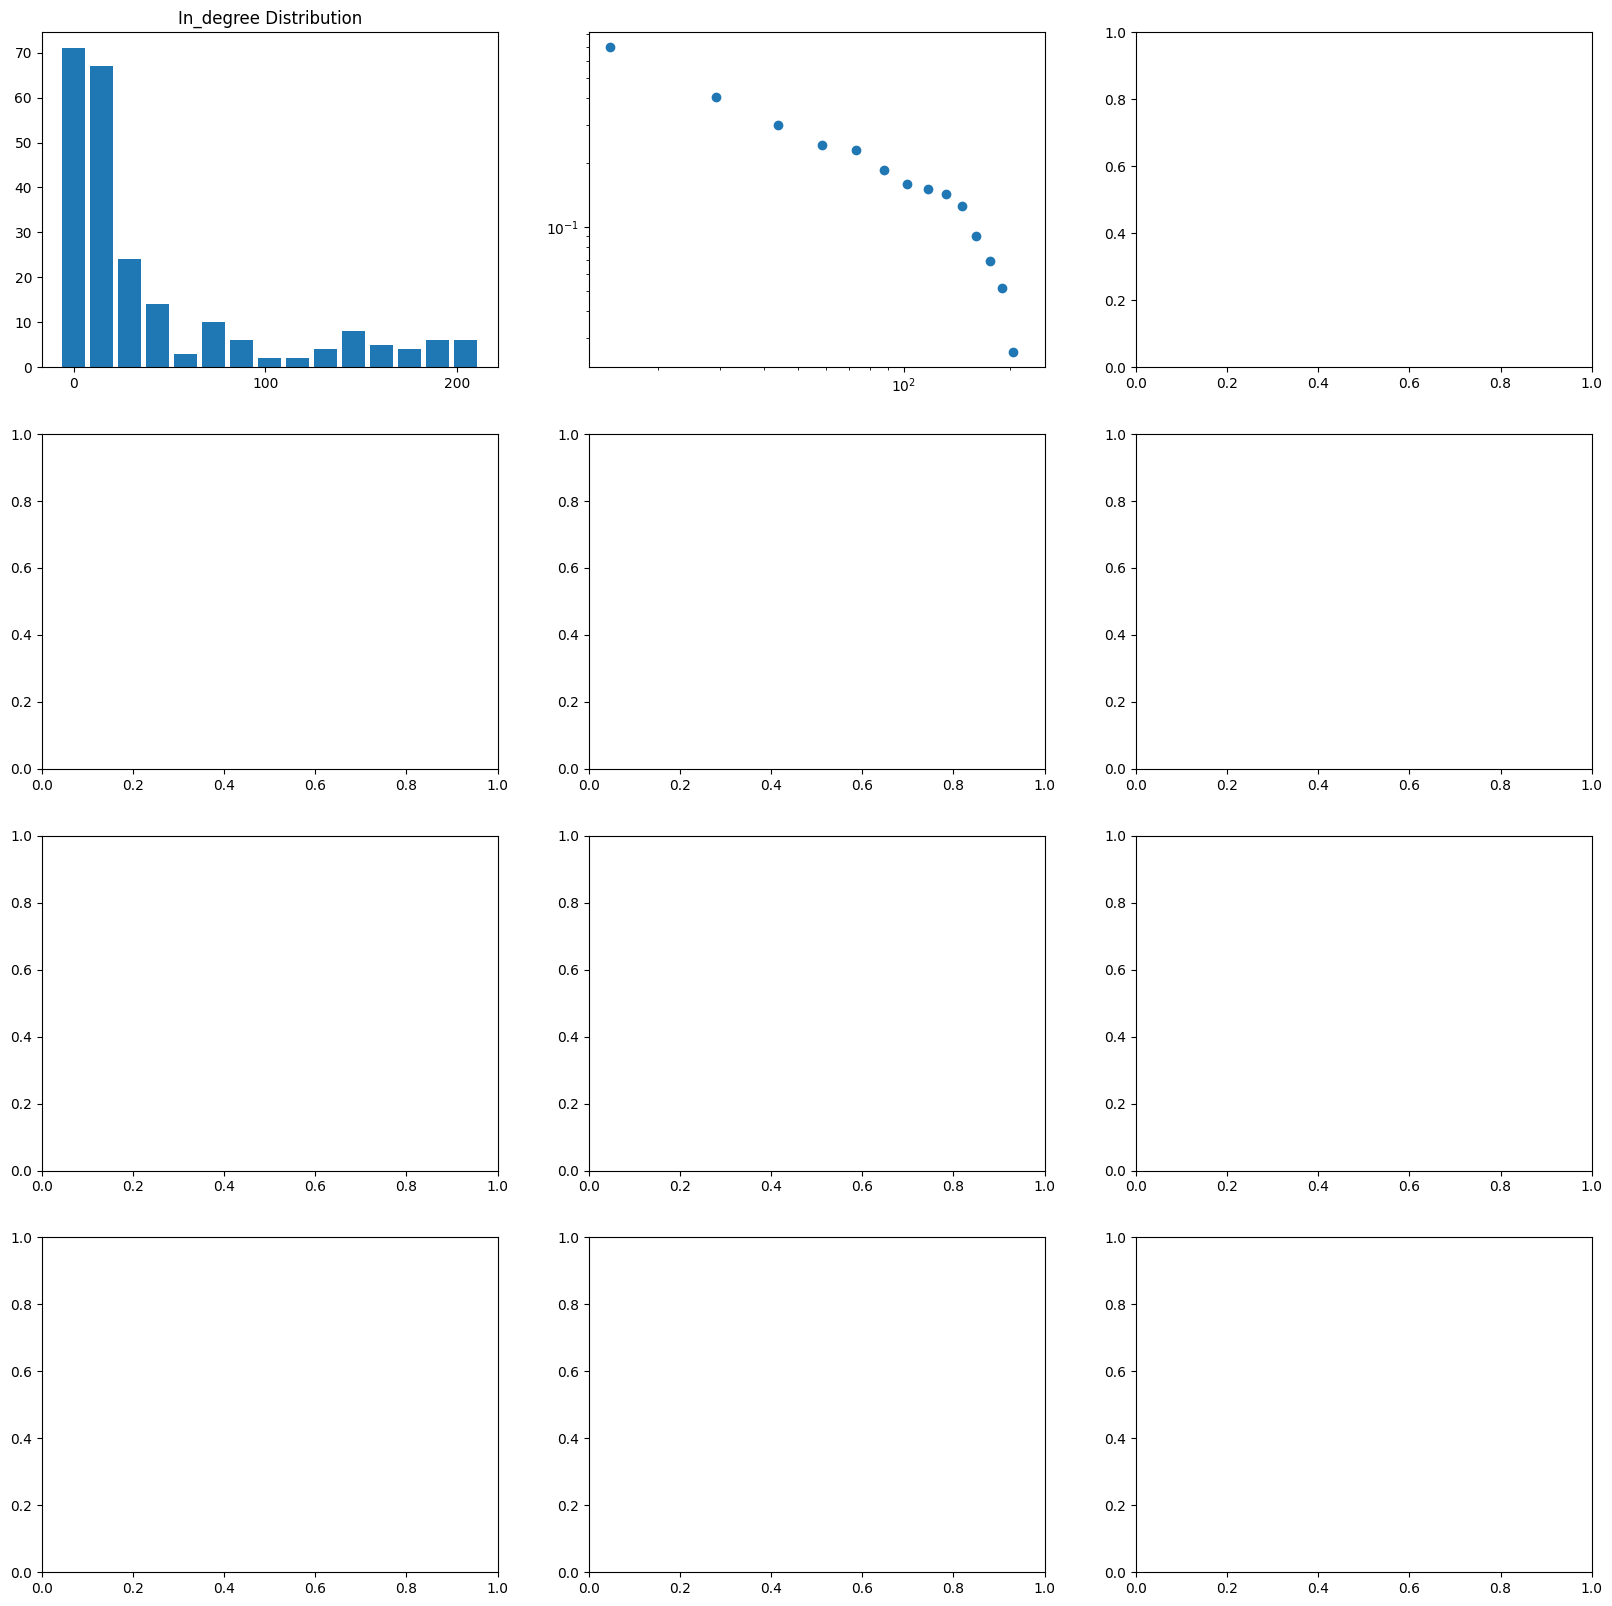

In [20]:
_, subp2 = plt.subplots(4, 3, figsize=(20, 20))
for idx, key in enumerate(list(centralities.keys())[:4]):
    vals = list(centralities[key].values())
    counts, bins , _ = subp2[idx][0].hist(centralities[key].values(), align='left', rwidth=0.8, bins = "auto")
    cdf = np.cumsum(counts)/np.sum(counts)
    ccdf = 1 - cdf
    subp2[idx][0].set(title = f'{key} Distribution', 
                      xticks = range(0, max(centralities[key].values()), closest_power_of_10(max(centralities[key].values()))))
    subp2[idx][1].loglog(bins[1:], ccdf, label='CCDF', marker='o', linestyle='none')
plt.show()

## Topological Indices

In [42]:
def topological(ind, txt):
    avg = sum(ind)/len(ind)
    print(f"The average {txt} is:", avg)
    max_i = max(ind)
    print(f"The maximum {txt} is", max_i)

In [109]:
for k, v in centralities.items():
    topological(v.values(), k)

The average In_degree is: 48.39655172413793
The maximum In_degree is 219
The average Out_degree is: 48.39655172413793
The maximum Out_degree is 161
The average In_strength is: 4696482.0
The maximum In_strength is 198572669
The average Out_strength is: 4696482.0
The maximum Out_strength is 66732561
The average Betweenness is: 0.003892534252354343
The maximum Betweenness is 0.09051453704505535
The average Closeness is: 0.5480489731740927
The maximum Closeness is 0.9506172839506173
The average Katz is: 0.02990310119005147
The maximum Katz is 0.5801589386372801
The average Left_Eigenvector is: 0.011859383390974126
The maximum Left_Eigenvector is 0.6829496571851886
The average Right_Eigenvector is: 0.012830327992105916
The maximum Right_Eigenvector is 0.6528323294907126
The average Harmonic Closeness is: 135.05064655172416
The maximum Harmonic Closeness is 225.0
